Checking for invalid images in the dataset...
No invalid images found in the dataset.
Found 483 images belonging to 8 classes.
Found 118 images belonging to 8 classes.
Number of classes detected: 8
Class mapping: {'IC-5332': 0, 'M-74': 1, 'NGC-4499': 2, 'NGC188': 3, 'NGC3256_nuc1': 4, 'NGC_1365': 5, 'NGC_1433': 6, 'NGC_628': 7}
Training the top layers...
Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.1697 - loss: 2.3080 - val_accuracy: 0.3051 - val_loss: 1.9895 - learning_rate: 1.0000e-04
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.2597 - loss: 2.0212 - val_accuracy: 0.3051 - val_loss: 1.9451 - learning_rate: 1.0000e-04
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 826ms/step - accuracy: 0.2610 - loss: 2.0352 - val_accuracy: 0.3051 - val_loss: 1.9489 - learning_rate: 1.0000e-04
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 895ms/step - accuracy: 0.2910 - loss: 1.9760 - val_accuracy: 0.3051 - val_loss: 1.9304 - learning_rate: 1.0000e-04
Epoch 5/100
16/16

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


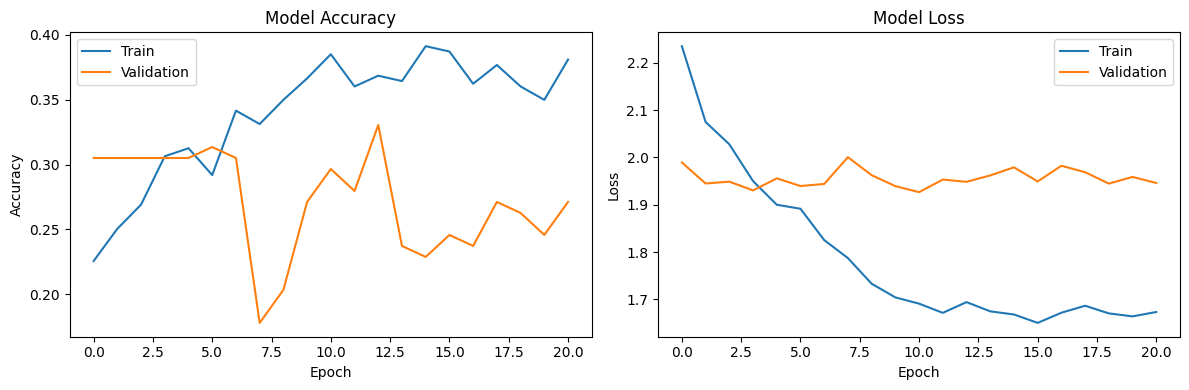

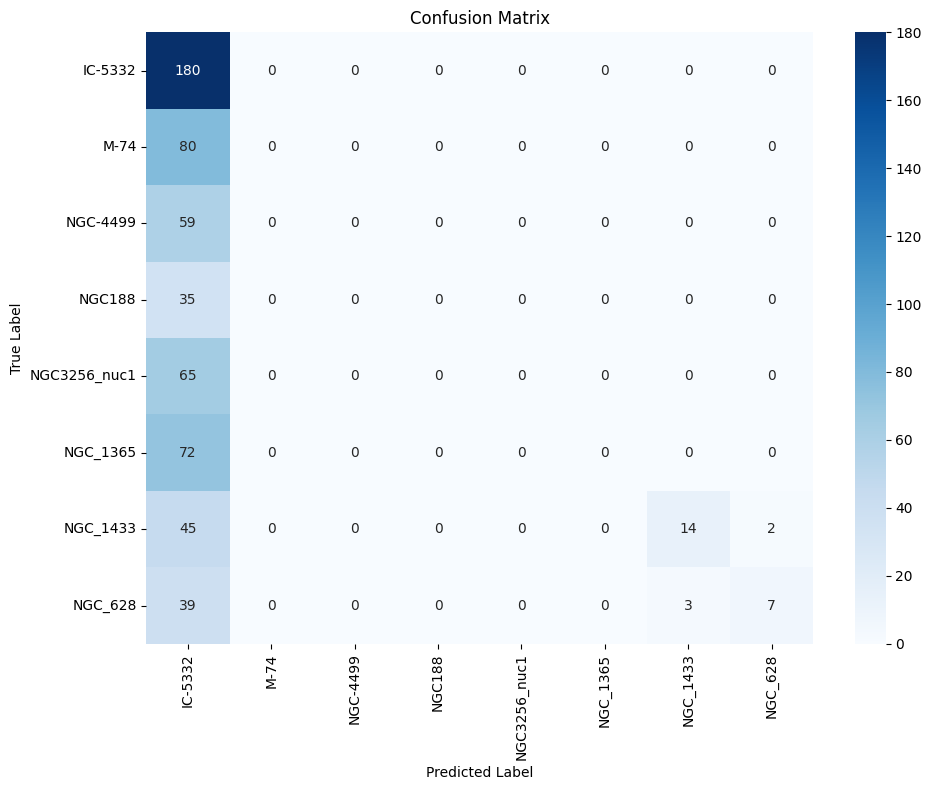

In [4]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
    ReduceLROnPlateau
)
from PIL import UnidentifiedImageError, Image
import warnings

# Configuration
IMG_SIZE = 224  # ResNet50 default input size
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 0.0001

def create_model(num_classes):
    # Load ResNet50 with pre-trained weights
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom top layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)  # Add dropout to prevent overfitting
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model, base_model

def setup_data_generators():
    """Set up data generators with augmentation."""
    # Custom validation function to filter out invalid images
    def validate_image(x):
        try:
            Image.open(BytesIO(x))
            return True
        except:
            return False

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest',
        validation_split=0.2
    )

    test_datagen = ImageDataGenerator(rescale=1./255)

    return train_datagen, test_datagen

def clean_dataset(data_dir):
    """Remove or identify invalid image files in the dataset."""
    invalid_files = []
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                # Attempt to open the file as an image
                img = Image.open(file_path)
                img.verify()  # Verify it's a valid image
                img.close()

                # Also try to load it fully to catch more subtle issues
                img = Image.open(file_path)
                img.load()
                img.close()
            except (IOError, SyntaxError, UnidentifiedImageError) as e:
                print(f"Invalid image found: {file_path}, Error: {str(e)}")
                invalid_files.append(file_path)

    return invalid_files

def plot_training_history(history):
    """Plot training history."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Accuracy plot
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['Train', 'Validation'])

    # Loss plot
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(['Train', 'Validation'])

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes):
    """Plot confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

def main():
    # Set up data paths
    data_dir = '/content/drive/MyDrive/Ml-project/Project-Review-3 /Dataset'  # Replace with your dataset path

    # First, clean the dataset to identify invalid images
    print("Checking for invalid images in the dataset...")
    invalid_files = clean_dataset(data_dir)

    if invalid_files:
        print(f"Found {len(invalid_files)} invalid image files.")
        print("You can either remove these files manually or the script will skip them during processing.")
        # Optionally, add code here to automatically remove invalid files if desired
    else:
        print("No invalid images found in the dataset.")

    # Set up data generators with exception handling
    train_datagen, test_datagen = setup_data_generators()

    # Add error handling around the flow_from_directory calls
    try:
        # Load and prepare the data with exception handling
        train_generator = train_datagen.flow_from_directory(
            data_dir,
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            subset='training'
        )

        validation_generator = train_datagen.flow_from_directory(
            data_dir,
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            subset='validation'
        )
    except Exception as e:
        print(f"Error setting up data generators: {str(e)}")
        print("Please check your dataset structure and fix any corrupt images.")
        return

    # Get number of classes
    num_classes = len(train_generator.class_indices)
    print(f"Number of classes detected: {num_classes}")
    print(f"Class mapping: {train_generator.class_indices}")

    # Create and compile the model
    model, base_model = create_model(num_classes)

    # Set up callbacks
    callbacks = [
       ModelCheckpoint(
            '/content/drive/MyDrive/Ml-project/Project-Review-3/best_model_2.keras',  # Save in a specific folder
            monitor='val_accuracy',
            save_best_only=True,
            mode='max'
       ),
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-6
        )
    ]

    # Train the model with exception handling
    try:
        print("Training the top layers...")
        history = model.fit(
            train_generator,
            epochs=EPOCHS,
            validation_data=validation_generator,
            callbacks=callbacks
        )

        # Fine-tune the model
        print("Fine-tuning the model...")
        # Unfreeze the last 30 layers of the base model
        for layer in base_model.layers[-30:]:
            layer.trainable = True

        # Recompile the model with a lower learning rate
        model.compile(
            optimizer=Adam(learning_rate=LEARNING_RATE/10),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        # Continue training
        history_fine = model.fit(
            train_generator,
            epochs=EPOCHS//2,
            validation_data=validation_generator,
            callbacks=callbacks
        )
    except Exception as e:
        print(f"Error during training: {str(e)}")
        return

    # Evaluate the model with exception handling
    try:
        print("Evaluating the model...")
        test_generator = test_datagen.flow_from_directory(
            data_dir,
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            shuffle=False
        )

        # Get predictions
        predictions = model.predict(test_generator)
        y_pred = np.argmax(predictions, axis=1)
        y_true = test_generator.classes

        # Print classification report
        class_names = list(test_generator.class_indices.keys())
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, target_names=class_names))

        # Plot training history and confusion matrix
        plot_training_history(history)
        plot_confusion_matrix(y_true, y_pred, class_names)
    except Exception as e:
        print(f"Error during evaluation: {str(e)}")

if __name__ == "__main__":
    # Add BytesIO import for the validate_image function
    from io import BytesIO
    main()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Checking for invalid images in the dataset...
No invalid images found in the dataset.
Creating a balanced dataset with 50 images per class...
Class NGC188: Selecting 35 out of 35 images
Class IC-5332: Selecting 50 out of 180 images
Class NGC_628: Selecting 49 out of 49 images
Class NGC_1433: Selecting 50 out of 61 images
Class NGC_1365: Selecting 50 out of 72 images
Class NGC3256_nuc1: Selecting 50 out of 65 images
Class M-74: Selecting 50 out of 80 images
Class NGC-4499: Selecting 50 out of 59 images
Balanced dataset created at: /content/drive/MyDrive/Ml-project/Project-Review-3 /Dataset_balanced
Found 308 images belonging to 8 classes.
Found 76 images belonging to 8 classes.
Number of classes detected: 8
Class mapping: {'IC-5332': 0, 'M-74': 1, 'NGC-4499': 2, 'NGC188': 3, 'NGC3256_nuc1': 4, 'NGC_1365': 5, 'NGC_1433': 6, 'NGC_628': 7}
Training samples: 308
Validation samples: 76


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 26,214,792 (100.00 MB)

 Trainable params: 2,627,080 (10.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Training the top layers...
Steps per epoch: 9
Validation steps: 2


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.1346 - loss: 2.3715 - val_accuracy: 0.1250 - val_loss: 2.0893 - learning_rate: 1.0000e-04
Epoch 2/100
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.0312 - loss: 2.3550

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 310ms/step - accuracy: 0.0312 - loss: 2.3550 - val_accuracy: 0.1406 - val_loss: 2.0722 - learning_rate: 1.0000e-04
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.1246 - loss: 2.2737 - val_accuracy: 0.1875 - val_loss: 2.0769 - learning_rate: 1.0000e-04
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 315ms/step - accuracy: 0.1562 - loss: 2.2758 - val_accuracy: 0.2031 - val_loss: 2.0660 - learning_rate: 1.0000e-04
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 926ms/step - accuracy: 0.1621 - loss: 2.2892 - val_accuracy: 0.1719 - val_loss: 2.0477 - learning_rate: 1.0000e-04
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 422ms/step - accuracy: 0.0938 - loss: 2.2898 - val_accuracy: 0.1406 - val_loss: 2.0614 - learning_rate: 1.0000e-04
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 876ms/step - accuracy: 0.1712 - loss: 2.1471 - val_accuracy: 0.2188 - val_loss: 2.0613 - learning_rate: 1.0000e-04
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 464ms/step - accuracy: 0.1562 - loss: 2.1551

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


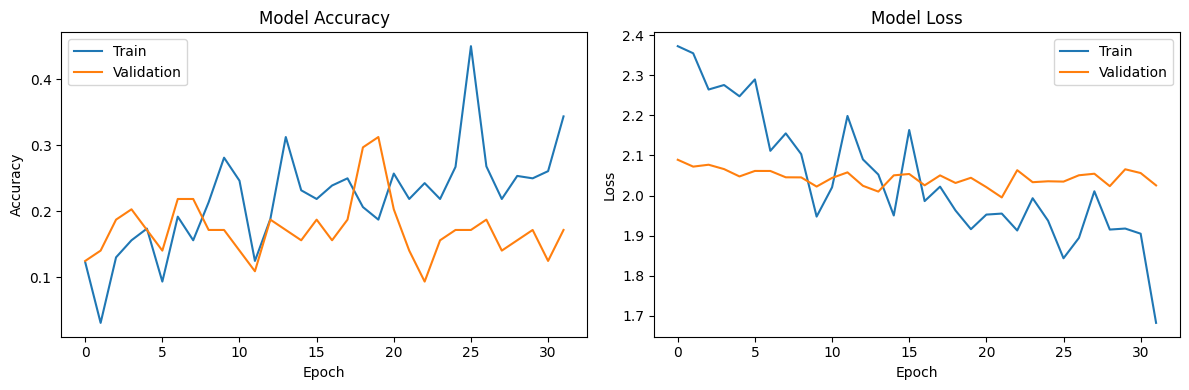

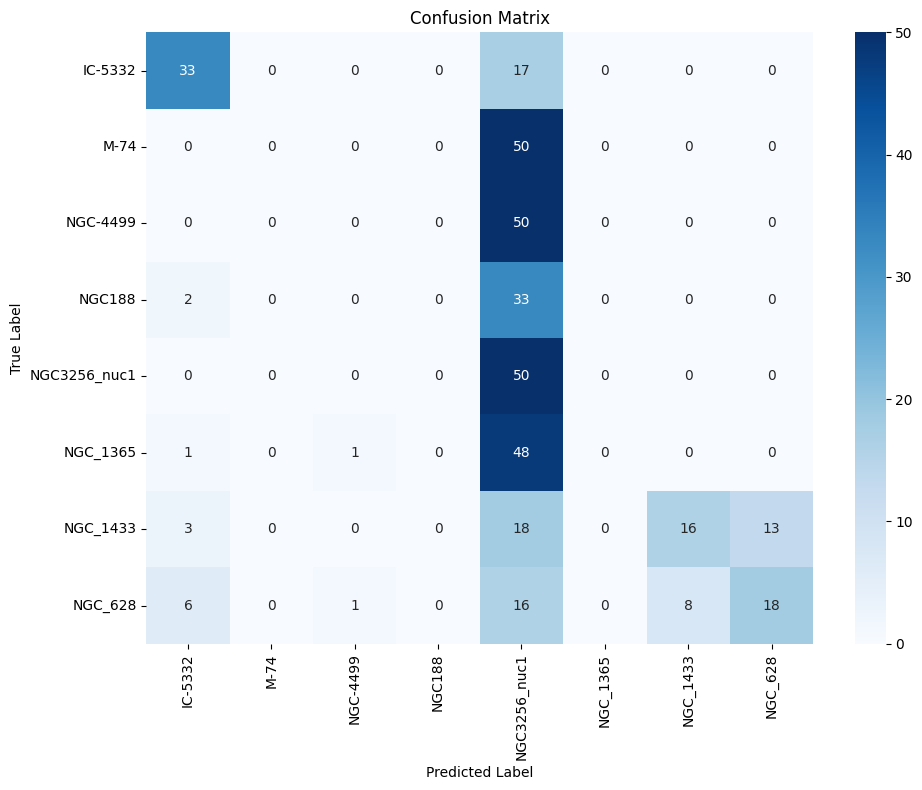

In [5]:
import os
import numpy as np
import shutil
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
    ReduceLROnPlateau
)
from PIL import UnidentifiedImageError, Image
import warnings
from io import BytesIO

# Configuration
IMG_SIZE = 224  # ResNet50 default input size
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 0.0001
IMAGES_PER_CLASS = 50  # Limit to 50 images per class

def create_model(num_classes):
    # Load ResNet50 with pre-trained weights
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom top layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)  # Add dropout to prevent overfitting
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model, base_model

def setup_data_generators():
    """Set up data generators with augmentation."""
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest',
        validation_split=0.2
    )

    test_datagen = ImageDataGenerator(rescale=1./255)

    return train_datagen, test_datagen

def clean_dataset(data_dir):
    """Remove or identify invalid image files in the dataset."""
    invalid_files = []
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                # Attempt to open the file as an image
                img = Image.open(file_path)
                img.verify()  # Verify it's a valid image
                img.close()

                # Also try to load it fully to catch more subtle issues
                img = Image.open(file_path)
                img.load()
                img.close()
            except (IOError, SyntaxError, UnidentifiedImageError) as e:
                print(f"Invalid image found: {file_path}, Error: {str(e)}")
                invalid_files.append(file_path)

    return invalid_files

def plot_training_history(history):
    """Plot training history."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Accuracy plot
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['Train', 'Validation'])

    # Loss plot
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(['Train', 'Validation'])

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes):
    """Plot confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

def create_balanced_dataset(original_data_dir, max_images=50):
    """
    Create a balanced dataset with a maximum number of images per class.
    Returns the path to the new balanced dataset directory.
    """
    # Create a temporary directory for the balanced dataset
    balanced_dir = original_data_dir + "_balanced"

    # Remove the balanced directory if it already exists
    if os.path.exists(balanced_dir):
        shutil.rmtree(balanced_dir)

    # Create the balanced directory
    os.makedirs(balanced_dir, exist_ok=True)

    # Process each class directory
    for class_name in os.listdir(original_data_dir):
        class_dir = os.path.join(original_data_dir, class_name)

        # Skip if not a directory
        if not os.path.isdir(class_dir):
            continue

        # Create the corresponding class directory in the balanced dataset
        balanced_class_dir = os.path.join(balanced_dir, class_name)
        os.makedirs(balanced_class_dir, exist_ok=True)

        # List all valid image files in the class directory
        valid_images = []
        for file in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file)
            try:
                if os.path.isfile(file_path):
                    img = Image.open(file_path)
                    img.verify()
                    img.close()
                    valid_images.append(file)
            except (IOError, SyntaxError, UnidentifiedImageError):
                continue

        # Select up to max_images images randomly
        selected_images = valid_images
        if len(valid_images) > max_images:
            selected_images = random.sample(valid_images, max_images)

        print(f"Class {class_name}: Selecting {len(selected_images)} out of {len(valid_images)} images")

        # Copy the selected images to the balanced class directory
        for file in selected_images:
            src = os.path.join(class_dir, file)
            dst = os.path.join(balanced_class_dir, file)
            shutil.copy2(src, dst)

    return balanced_dir

def main():
    # Set up data paths
    original_data_dir = '/content/drive/MyDrive/Ml-project/Project-Review-3 /Dataset'  # Replace with your dataset path

    # First, clean the dataset to identify invalid images
    print("Checking for invalid images in the dataset...")
    invalid_files = clean_dataset(original_data_dir)

    if invalid_files:
        print(f"Found {len(invalid_files)} invalid image files.")
        print("You can either remove these files manually or the script will skip them during processing.")
    else:
        print("No invalid images found in the dataset.")

    # Create a balanced dataset with at most 50 images per class
    print(f"Creating a balanced dataset with {IMAGES_PER_CLASS} images per class...")
    data_dir = create_balanced_dataset(original_data_dir, IMAGES_PER_CLASS)
    print(f"Balanced dataset created at: {data_dir}")

    # Set up data generators
    train_datagen, test_datagen = setup_data_generators()

    try:
        # Load and prepare the data with exception handling
        train_generator = train_datagen.flow_from_directory(
            data_dir,
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            subset='training'
        )

        validation_generator = train_datagen.flow_from_directory(
            data_dir,
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            subset='validation'
        )
    except Exception as e:
        print(f"Error setting up data generators: {str(e)}")
        print("Please check your dataset structure and fix any corrupt images.")
        return

    # Get number of classes
    num_classes = len(train_generator.class_indices)
    print(f"Number of classes detected: {num_classes}")
    print(f"Class mapping: {train_generator.class_indices}")

    # Print dataset statistics
    print(f"Training samples: {train_generator.samples}")
    print(f"Validation samples: {validation_generator.samples}")

    # Create and compile the model
    model, base_model = create_model(num_classes)

    # Print model summary
    model.summary()

    # Set up callbacks
    callbacks = [
        ModelCheckpoint(
            '/content/drive/MyDrive/Ml-project/Project-Review-3/best_model_balanced.keras',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max'
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-6
        )
    ]

    # Train the model with exception handling
    try:
        print("Training the top layers...")
        # Make sure steps_per_epoch and validation_steps are specified
        steps_per_epoch = train_generator.samples // BATCH_SIZE
        validation_steps = validation_generator.samples // BATCH_SIZE

        # Ensure at least 1 step per epoch
        steps_per_epoch = max(1, steps_per_epoch)
        validation_steps = max(1, validation_steps)

        print(f"Steps per epoch: {steps_per_epoch}")
        print(f"Validation steps: {validation_steps}")

        history = model.fit(
            train_generator,
            epochs=EPOCHS,
            steps_per_epoch=steps_per_epoch,
            validation_data=validation_generator,
            validation_steps=validation_steps,
            callbacks=callbacks,
            verbose=1
        )

        # Fine-tune the model
        print("Fine-tuning the model...")
        # Unfreeze the last 30 layers of the base model
        for layer in base_model.layers[-30:]:
            layer.trainable = True

        # Recompile the model with a lower learning rate
        model.compile(
            optimizer=Adam(learning_rate=LEARNING_RATE/10),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        # Continue training
        history_fine = model.fit(
            train_generator,
            epochs=EPOCHS//2,
            steps_per_epoch=steps_per_epoch,
            validation_data=validation_generator,
            validation_steps=validation_steps,
            callbacks=callbacks,
            verbose=1
        )
    except Exception as e:
        print(f"Error during training: {str(e)}")
        return

    # Evaluate the model with exception handling
    try:
        print("Evaluating the model...")
        test_generator = test_datagen.flow_from_directory(
            data_dir,
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            shuffle=False
        )

        # Make sure we set steps correctly
        eval_steps = test_generator.samples // BATCH_SIZE
        eval_steps = max(1, eval_steps)

        # Get predictions
        predictions = model.predict(test_generator, steps=eval_steps)
        y_pred = np.argmax(predictions, axis=1)
        y_true = test_generator.classes[:len(y_pred)]  # Ensure same length

        # Print classification report
        class_names = list(test_generator.class_indices.keys())
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, target_names=class_names))

        # Plot training history and confusion matrix
        plot_training_history(history)
        plot_confusion_matrix(y_true, y_pred, class_names)
    except Exception as e:
        print(f"Error during evaluation: {str(e)}")

if __name__ == "__main__":
    main()

Found 483 images belonging to 8 classes.
Found 118 images belonging to 8 classes.
Training the top layers...
Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 265s 16s/step - accuracy: 0.2119 - loss: 2.2048 - val_accuracy: 0.3051 - val_loss: 1.9655 - learning_rate: 1.0000e-04
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 993ms/step - accuracy: 0.2786 - loss: 2.0616 - val_accuracy: 0.3051 - val_loss: 1.9464 - learning_rate: 1.0000e-04
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 808ms/step - accuracy: 0.2606 - loss: 2.0340 - val_accuracy: 0.3051 - val_loss: 1.9382 - learning_rate: 1.0000e-04
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 888ms/step - accuracy: 0.3008 - loss: 1.9191 - val_accuracy: 0.3136 - val_loss: 1.9213 - learning_rate: 1.0000e-04
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 930ms/step - accuracy: 0.3214 - loss: 1.8170 - val_accuracy: 0.2288 - val_loss: 1.9737 - learning_rate: 1.0000e-04
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 913ms/step - accuracy: 0.3481 - loss: 1.7687 - val_accuracy: 0.30

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


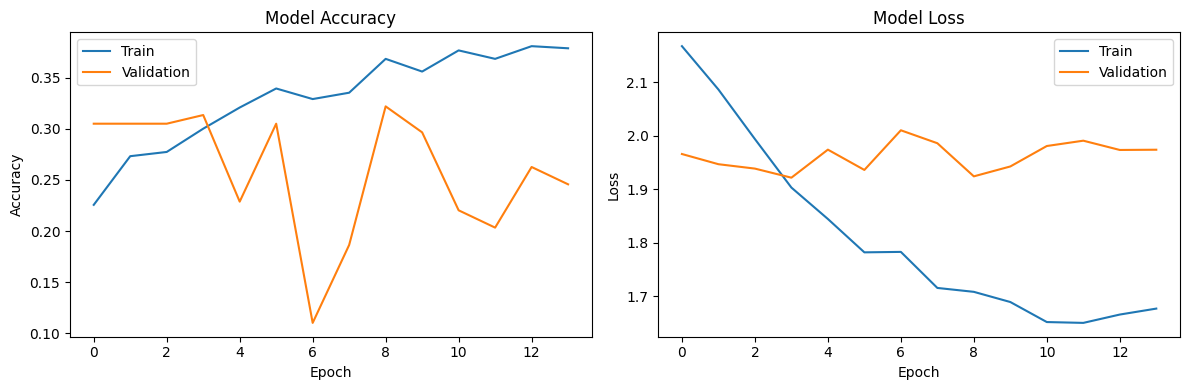

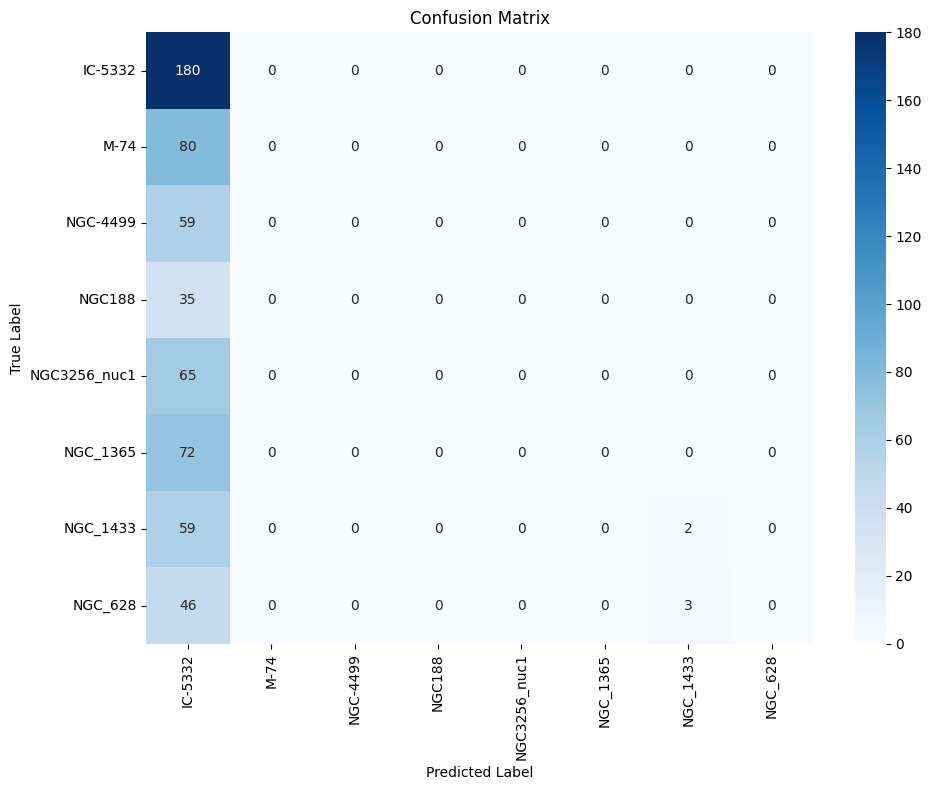

In [3]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
    ReduceLROnPlateau
)

# Configuration
IMG_SIZE = 224  # ResNet50 default input size
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.0001

def create_model(num_classes):

    # Load ResNet50 with pre-trained weights
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom top layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)  # Add dropout to prevent overfitting
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model, base_model

def setup_data_generators():
    """Set up data generators with augmentation."""
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest',
        validation_split=0.2
    )

    test_datagen = ImageDataGenerator(rescale=1./255)

    return train_datagen, test_datagen

def plot_training_history(history):
    """Plot training history."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Accuracy plot
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['Train', 'Validation'])

    # Loss plot
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(['Train', 'Validation'])

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes):
    """Plot confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

def main():
    # Set up data paths
    data_dir = '/content/drive/MyDrive/Ml-project/Project-Review-3 /Dataset'  # Replace with your dataset path

    # Set up data generators
    train_datagen, test_datagen = setup_data_generators()

    # Load and prepare the data
    train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training'
    )

    validation_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation'
    )

    # Get number of classes
    num_classes = len(train_generator.class_indices)

    # Create and compile the model
    model, base_model = create_model(num_classes)

    # Set up callbacks
    callbacks = [
       ModelCheckpoint(
            '/content/drive/MyDrive/Ml-project/Project-Review  3/best_model.keras',  # Save in a specific folder
            monitor='val_accuracy',
            save_best_only=True,
            mode='max'
       ),
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-6
        )
    ]

    # Train the model
    print("Training the top layers...")
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=validation_generator,
        callbacks=callbacks
    )

    # Fine-tune the model
    print("Fine-tuning the model...")
    # Unfreeze the last 30 layers of the base model
    for layer in base_model.layers[-30:]:
        layer.trainable = True

    # Recompile the model with a lower learning rate
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE/10),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Continue training
    history_fine = model.fit(
        train_generator,
        epochs=EPOCHS//2,
        validation_data=validation_generator,
        callbacks=callbacks
    )

    # Evaluate the model
    print("Evaluating the model...")
    test_generator = test_datagen.flow_from_directory(
        data_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    # Get predictions
    predictions = model.predict(test_generator)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes

    # Print classification report
    class_names = list(test_generator.class_indices.keys())
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Plot training history and confusion matrix
    plot_training_history(history)
    plot_confusion_matrix(y_true, y_pred, class_names)

if __name__ == "__main__":
    main()